In [60]:
import sys
import numpy as np
import os
from image_utils import standardize,distance_map_batch,distance_map_batch_v2
from IOU_computations import *
from numpy import newaxis
import matplotlib.pyplot as plt
from dataset_generator_2 import Dataset_sat

import logging
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch
from resunet_main_fin_new_save import predict,criterion
import torch.backends.cudnn as cudnn
import json
from random import randint

In [61]:
!gpustat

cronus  Mon May 14 21:55:19 2018
[0] GeForce GTX TITAN X | 81'C,  89 % | 11673 / 12207 MB | pbjo(11662M)
[1] GeForce GTX TITAN X | 36'C,   0 % |   858 / 12207 MB | caskaae(509M) caskaae(338M)
[2] GeForce GTX TITAN X | 83'C,  96 % | 11721 / 12207 MB | dmal(11710M)
[3] GeForce GTX TITAN X | 55'C,   0 % |  4501 / 12207 MB | s161362(4490M)
[4] GeForce GTX TITAN X | 40'C,   0 % |     0 / 12207 MB |
[5] GeForce GTX TITAN X | 40'C,   0 % |     0 / 12207 MB |
[6] GeForce GTX TITAN X | 40'C,   0 % |     0 / 12207 MB |
[7] GeForce GTX TITAN X | 41'C,   2 % |     0 / 12207 MB |


In [62]:
INPUT_CHANNELS=9
NB_CLASSES=2


###############
DEFAULT_LAYERS=3
DEFAULT_FEATURES_ROOT=32
BATCH_NORM=True

#################
DEFAULT_FILTER_WIDTH=3
DEFAULT_PADDING=1


# DISTANCE_NET='v1'
BINS=15
THRESHOLD=33

# DISTANCE_NET='v2'
# BINS=10
# THRESHOLD=20
# DISTANCE_NET=None

###
DEFAULT_N_RESBLOCKS=1
N_DILATED_CONV=3
DEFAULT_GATED=False
DEFAULT_GROUP_NORM=0

####
DEFAULT_HIDDEN_FEATURES=[32,64,128,256]
DEFAULT_N_RESBLOCKS=1
N_DILATED_CONV=3
DEFAULT_GATED=False
DEFAULT_GROUP_NORM=0
DEFAULT_PADDING=1

###
DEFAULT_HIDDEN_FEATURES_DILATED=[32,64,128,256]

WEIGHTS_INIT=False

In [63]:
def plot_summary(predictions,labels,pansharp,batch_size,batch_number,prediction_path,display='all'):
    
    if display=='all':
        fig,axs=plt.subplots(3, batch_size,figsize=(8*batch_size,24))

        axs[0,0].set_title(str(batch_number)+' Pansharpened ', fontsize='large')
        axs[1,0].set_title(str(batch_number)+' Groundtruth ', fontsize='large')
        axs[2,0].set_title(str(batch_number)+' Predictions ', fontsize='large')


        for i in range(batch_size):

            axs[0,i].imshow(pansharp[i])
            plt.imsave(prediction_path+'_'+str(batch_number)+'_Pansharpened_'+str(i)+'.jpg',pansharp[i])
            axs[1,i].imshow(labels[i])
            plt.imsave(prediction_path+'_'+str(batch_number)+'_Groundtruth_'+str(i)+'.jpg',labels[i])
            axs[2,i].imshow(predictions[i])
            plt.imsave(prediction_path+'_'+str(batch_number)+'_Predictions_'+str(i)+'.jpg',predictions[i])
    
    else:
        fig,axs=plt.subplots(1, batch_size,figsize=(8*batch_size,24))
        axs[0].set_title(str(batch_number)+' Predictions ', fontsize='large')
        for i in range(batch_size):
            axs[i].imshow(predictions[i])
            plt.imsave(prediction_path+'_'+str(batch_number)+'_Predictions_'+str(i)+'.jpg',predictions[i])
        

    plt.show()



In [64]:
def generate_dataset(path_validation,validation_batch_size):
    val_generator=Dataset_sat.from_root_folder(path_validation,NB_CLASSES)
    val_loader = DataLoader(val_generator, batch_size=validation_batch_size,shuffle=False, num_workers=1)
    
    return val_loader

In [65]:
def error_rate(predictions, labels):
    """
    Return the error rate based on dense predictions and 1-hot labels.
    """

    return 100.0 - (
        100.0 *
        np.sum(np.argmax(predictions, 3) == np.argmax(labels, 3)) /
        (predictions.shape[0]*predictions.shape[1]*predictions.shape[2]))

In [66]:
def compute_test_set_metrics(val_loader,RBD,prediction_path,file_results,net, distance_net=None,model_name=''):
    
    TMP_IOU=prediction_path+'TMP_IOU/'
    if not os.path.exists(TMP_IOU):
        os.makedirs(TMP_IOU)

    loss_fn=nn.CrossEntropyLoss()
    loss_v=0
    error_v=0
    iou_acc_v=0
    f1_v=0
    
    

    for i_batch,sample in enumerate(val_loader):
        batch_x=standardize(sample['input'])
        batch_y=sample['groundtruth']

        X = Variable(batch_x.float())
        X=X.permute(0,3,1,2).cuda()  
        Y = Variable(batch_y.float())
        Y=Y.cuda()
        if distance_net=='v1' or distance_net=='v2':
            if distance_net=='v1':
                y_dist=distance_map_batch(batch_y,THRESHOLD,BINS)
            elif distance_net=='v2':
                y_dist=distance_map_batch_2(batch_y,THRESHOLD,BINS)
                
            Y_dist = Variable(y_dist.float())
            Y_dist=Y_dist.cuda()
            probs_dist,probs_seg=predict(model,X,distance_net)
            loss_seg=criterion(Y,probs_seg)
            loss_dist=criterion(Y_dist,probs_dist)
            loss=loss_seg+loss_dist
            prediction_seg_v=probs_seg.data.cpu().numpy()
            groundtruth_seg_v=np.asarray(batch_y)
            prediction_dist_v=probs_dist.data.cpu().numpy()
            groundtruth_dist=np.asarray(y_dist)

        else:
            probs=predict(model,X)
            loss=criterion(Y,probs)
            prediction_seg_v=probs.data.cpu().numpy()
            groundtruth_seg_v=np.asarray(batch_y)
            prediction_dist_v=None
            groundtruth_dist=None

        loss_v+=loss.data[0]

        error_v+=error_rate(prediction_seg_v,groundtruth_seg_v)
        iou_acc,f1,iou=predict_score_batch(TMP_IOU,np.argmax(groundtruth_seg_v,3),np.argmax(prediction_seg_v,3))
        iou_acc_v+=iou_acc
        f1_v+=f1
        
        if i_batch==RBD:
            batch_x=np.asarray(batch_x)
            if batch_x.shape[-1]>3:
                pansharp=np.stack((batch_x[:,:,:,5],batch_x[:,:,:,3],batch_x[:,:,:,2]),axis=3)
            else:
                pansharp=batch_x
            plot_summary(np.argmax(prediction_seg_v,3),np.argmax(groundtruth_seg_v,3),pansharp,len(groundtruth_seg_v),i_batch,prediction_path,display='all')

    loss_v/=val_loader.__len__()
    error_v/=val_loader.__len__()  
    iou_acc_v/=val_loader.__len__()  
    f1_v/=val_loader.__len__()  
    logging.info("Model {:s}: Verif loss = {:.4f}, Verification  Error rate = {:.4f}%, IOU Precision = {:.4f}%, F1 IOU= {:.4f}%".format(model_name,loss_v,error_v,iou_acc_v,f1_v))

    file_results.write(json.dumps({'name': model_name, 'loss':loss_v, 'Erro rate':error_v, 'IOU accuracy':iou_acc_v, 'F1 IOU': f1_v}))
    file_results.flush()
        

In [67]:
unet_v=6
distance_net=None

if distance_net=='v1' or distance_net=='v2':
    distance_net_unet=True
else:
    distance_net_unet=False
if unet_v==0:
    from unet_meli import UNet
    model=UNet(INPUT_CHANNELS,NB_CLASSES,depth =DEFAULT_LAYERS,n_features_zero =DEFAULT_FEATURES_ROOT,dropout=0,distance_net=distance_net_unet,bins=BINS,batch_norm=BATCH_NORM)
elif unet_v==1:
    from unet_val import UNet ##Original version with missing resl block first stage
    model=UNet(INPUT_CHANNELS,NB_CLASSES,depth =DEFAULT_LAYERS,n_features_zero =DEFAULT_FEATURES_ROOT,width_kernel=DEFAULT_FILTER_WIDTH,dropout=0,distance_net=distance_net_unet,bins=BINS,batch_norm=BATCH_NORM)
elif unet_v==2:
    from unet_val_2 import UNet
    model=UNet(INPUT_CHANNELS,NB_CLASSES,depth =DEFAULT_LAYERS,n_features_zero =DEFAULT_FEATURES_ROOT,width_kernel=DEFAULT_FILTER_WIDTH,dropout=0,distance_net=distance_net_unet,bins=BINS,batch_norm=BATCH_NORM)
elif unet_v==4:
    from unet_val_meli import UNet ##with extra dropout
    model=UNet(INPUT_CHANNELS,NB_CLASSES,depth =DEFAULT_LAYERS,n_features_zero =DEFAULT_FEATURES_ROOT,width_kernel=DEFAULT_FILTER_WIDTH,dropout=0,distance_net=distance_net_unet,bins=BINS,batch_norm=BATCH_NORM)
elif unet_v==3:
    from unet_val_gated_dilated import UNet
    model=UNet(INPUT_CHANNELS,NB_CLASSES,num_hidden_features =DEFAULT_HIDDEN_FEATURES,n_resblocks=DEFAULT_N_RESBLOCKS,num_dilated_convs=N_DILATED_CONV,dropout=0,gated=DEFAULT_GATED,kernel_size=DEFAULT_FILTER_WIDTH,padding=DEFAULT_PADDING, group_norm=DEFAULT_GROUP_NORM)
elif unet_v==5:
    from unet_dilated_meli import DilatedNetwork
    model=DilatedNetwork( INPUT_CHANNELS,NB_CLASSES,num_hidden_features=DEFAULT_HIDDEN_FEATURES_DILATED,n_resblocks=DEFAULT_N_RESBLOCKS, dropout=0, padding=DEFAULT_PADDING, kernel_size=DEFAULT_FILTER_WIDTH,batch_norm=BATCH_NORM)
elif unet_v==6:
    from unet_baseline_fin import UNet
    model=UNet(INPUT_CHANNELS,NB_CLASSES,depth =DEFAULT_LAYERS,n_features_zero =DEFAULT_FEATURES_ROOT,width_kernel=DEFAULT_FILTER_WIDTH,dropout=0,distance_net=distance_net_unet,bins=BINS,batch_norm=BATCH_NORM)

if WEIGHTS_INIT:
    model.apply(weights_init)

    

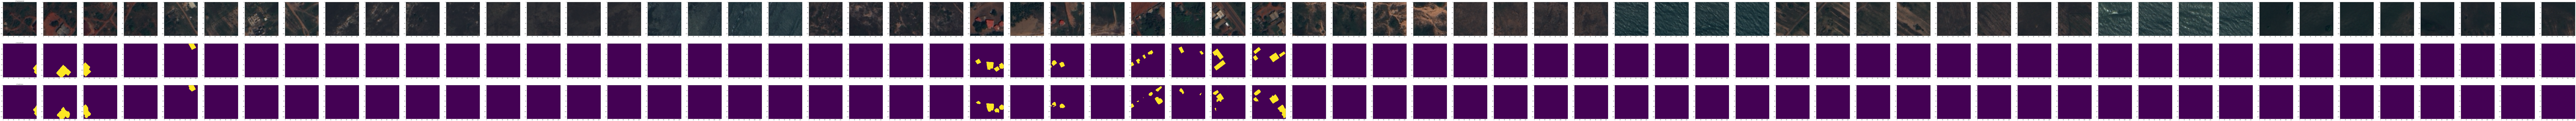

2018-05-14 21:58:51,240 Model MODEL GHANA L3 68: Verif loss = 0.0131, Verification  Error rate = 0.4951%, IOU Precision = 95.8277%, F1 IOU= 95.1737%


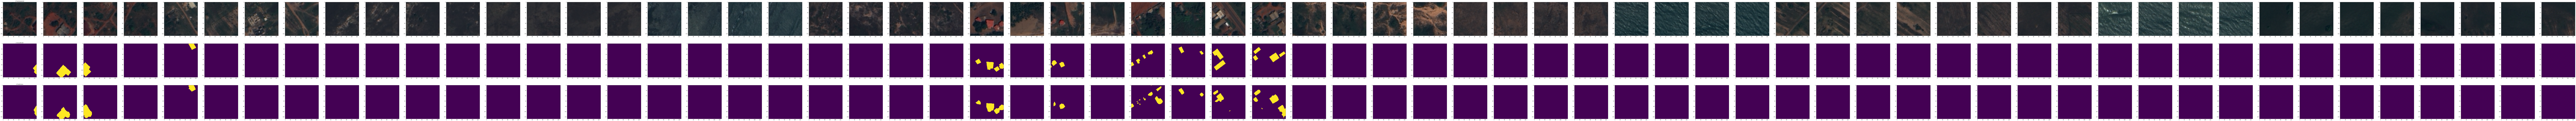

2018-05-14 22:01:44,225 Model MODEL GHANA L4 47: Verif loss = 0.0144, Verification  Error rate = 0.5314%, IOU Precision = 95.6969%, F1 IOU= 94.3795%


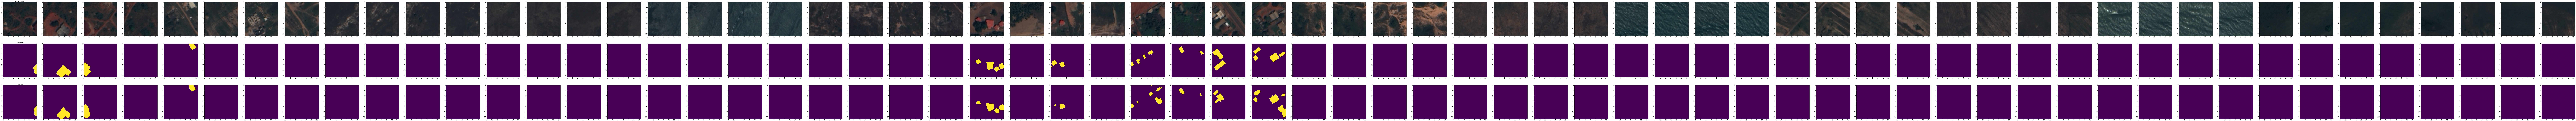

2018-05-14 22:04:35,987 Model MODEL GHANA L5 79: Verif loss = 0.0165, Verification  Error rate = 0.5419%, IOU Precision = 95.5878%, F1 IOU= 94.7631%


In [68]:
batch_size=64

# root_folder='../SPACENET_DATA/SPACENET_DATA_PROCESSED/DATASET/128_x_128_8_bands_pansh/'
root_folder ='../2_DATA_GHANA/DATASET/128_x_128_8_pansh/'
validation_loader=generate_dataset(root_folder+'TEST/',batch_size)

RBD=randint(0,int(validation_loader.__len__())-1)

##L3

prediction_path='TEST_SET_GHANA_L3_RESULTS/'
if not os.path.exists(prediction_path):
    os.makedirs(prediction_path)
file_results=open(prediction_path+'models_transfer_learning.txt','w')

distance_net=None
DEFAULT_LAYERS=3
model_name='MODEL GHANA L3 68'
restore_path='MODEL_GHANA_SIZE_PATCH_128_L3/RESUNET_ghana_size_patch_128_L3CP68.pth'
from unet_baseline_fin import UNet
model=UNet(INPUT_CHANNELS,NB_CLASSES,depth =DEFAULT_LAYERS,n_features_zero =DEFAULT_FEATURES_ROOT,width_kernel=DEFAULT_FILTER_WIDTH,dropout=0,distance_net=distance_net_unet,bins=BINS,batch_norm=BATCH_NORM)

model.cuda()
cudnn.benchmark = True
model.load_state_dict(torch.load(restore_path))
compute_test_set_metrics(validation_loader,RBD,prediction_path,file_results,model, distance_net=distance_net,model_name=model_name)

##L4

prediction_path='TEST_SET_GHANA_L4_RESULTS/'
if not os.path.exists(prediction_path):
    os.makedirs(prediction_path)
file_results=open(prediction_path+'models_transfer_learning.txt','w')

distance_net=None
DEFAULT_LAYERS=4
model_name='MODEL GHANA L4 47'
restore_path='MODEL_GHANA_SIZE_PATCH_128_L4/RESUNET_ghana_size_patch_128_L4CP47.pth'
from unet_baseline_fin import UNet
model=UNet(INPUT_CHANNELS,NB_CLASSES,depth =DEFAULT_LAYERS,n_features_zero =DEFAULT_FEATURES_ROOT,width_kernel=DEFAULT_FILTER_WIDTH,dropout=0,distance_net=distance_net_unet,bins=BINS,batch_norm=BATCH_NORM)

model.cuda()
cudnn.benchmark = True
model.load_state_dict(torch.load(restore_path))
compute_test_set_metrics(validation_loader,RBD,prediction_path,file_results,model, distance_net=distance_net,model_name=model_name)

##L5

prediction_path='TEST_SET_GHANA_L5_RESULTS/'
if not os.path.exists(prediction_path):
    os.makedirs(prediction_path)
file_results=open(prediction_path+'models_transfer_learning.txt','w')

distance_net=None
DEFAULT_LAYERS=5
model_name='MODEL GHANA L5 79'
restore_path='MODEL_GHANA_SIZE_PATCH_128_L5/RESUNET_ghana_size_patch_128_L5CP79.pth'
from unet_baseline_fin import UNet
model=UNet(INPUT_CHANNELS,NB_CLASSES,depth =DEFAULT_LAYERS,n_features_zero =DEFAULT_FEATURES_ROOT,width_kernel=DEFAULT_FILTER_WIDTH,dropout=0,distance_net=distance_net_unet,bins=BINS,batch_norm=BATCH_NORM)

model.cuda()
cudnn.benchmark = True
model.load_state_dict(torch.load(restore_path))
compute_test_set_metrics(validation_loader,RBD,prediction_path,file_results,model, distance_net=distance_net,model_name=model_name)
